In [1]:
!pip install benchmarx==0.0.10 --quiet

In [8]:
# Imports
from benchmarx import Benchmark, QuadraticProblem, CustomOptimizer
from benchmarx.src.custom_optimizer import State
import jax.numpy as jnp
from jax import random, grad

In [6]:
class MyGradientDescent(CustomOptimizer):
    def __init__(self, x_init, stepsize, problem, tol=1e-6, maxiter=400, label = 'MyGD'):
        params = {
            'x_init': x_init,
            'tol': tol,
            'maxiter': maxiter,
            'stepsize': stepsize
        }
        self.stepsize = stepsize
        self.problem = problem
        self.maxiter = maxiter
        self.tol = tol
        super().__init__(params=params, x_init=x_init, label=label)

    def init_state(self, x_init, *args, **kwargs) -> State:
        return State(
            iter_num=1,
            stepsize=self.stepsize
        )
    
    def update(self, sol, state: State) -> tuple([jnp.array, State]):
        sol -= state.stepsize * grad(self.problem.f)(sol)
        state.iter_num += 1
        state.stepsize = 1 / (state.iter_num + 1)
        return sol, state
    
    def stop_criterion(self, sol, state: State) -> bool:
        return jnp.linalg.norm(grad(self.problem.f)(sol))**2 < self.tol


In [16]:
n = 2
x_init = jnp.array([2.0, 1.0])
problem = QuadraticProblem(n=n)
benchmark = Benchmark(
    runs=2,
    problem=problem,
    methods=[
        {
            'MY_GRADIENT_DESCENT': {}
        },
        {
            'GRADIENT_DESCENT_const_step': {
                'x_init' : x_init,
                'tol': 1e-3,
                'maxiter': 50,
                'stepsize' : 1e-1,
                'acceleration': False,
                'label': 'GD_const'
            }
        }
    ],
    metrics=[
        "nit",
        "history_x",
        "history_f",
        "history_df"
    ],
)
my_solver = MyGradientDescent(
    x_init=x_init,
    stepsize=1e-2,
    problem=problem,
    tol=1e-3,
    maxiter=50,
    label='MyGD'
)

In [17]:
result = benchmark.run(user_method=my_solver)

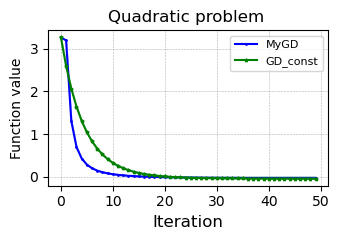

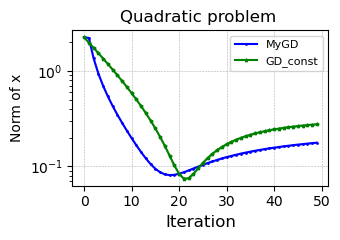

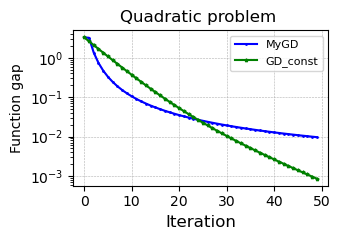

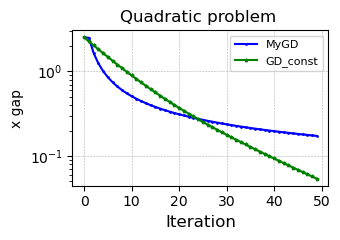

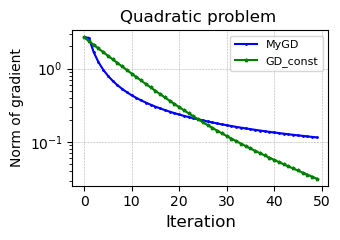

In [18]:
result.plot(
    metrics_to_plot= ['fs', 'xs_norm', 'f_gap', 'x_gap', 'grads_norm'],
    dir_path='plots',
    fname_append='qp_real',
    show=True,
    log=True 
)